# Emotions Classifier CNN Model (60 Epochs)

## Importing Libraries

In [1]:
import os
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import regularizers
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten

## Importing Dataset

In [2]:
train_dir = '../input/fer2013/train/'
test_dir = '../input/fer2013/test/'

row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       surprise  fear  angry  neutral   sad  disgust  happy
train      3171  4097   3995     4965  4830      436   7215
      surprise  fear  angry  neutral   sad  disgust  happy
test       831  1024    958     1233  1247      111   1774


### Plot of number of images in training set

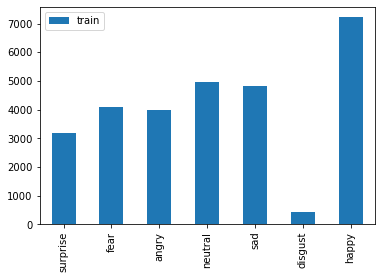

In [3]:
train_count.transpose().plot(kind='bar')

### Plot of number of images in test set

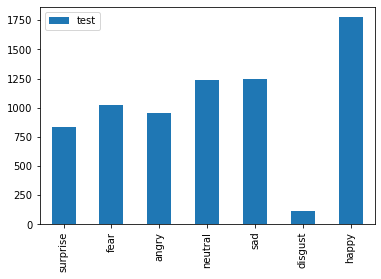

In [4]:
test_count.transpose().plot(kind='bar')

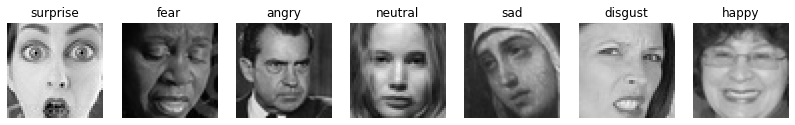

In [5]:
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

## Creating Training and test sets

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [7]:
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [8]:
test_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

## CNN Model

In [9]:
def get_model(input_size, classes=7):
     #Initialising the CNN
    model = tf.keras.models.Sequential()   

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(classes, activation='softmax'))

    #Compliling the model
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=1e-6)
    model.compile(optimizer=opt, 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [10]:
emotions_classifier = get_model((row,col,1), classes)
emotions_classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 256)       2

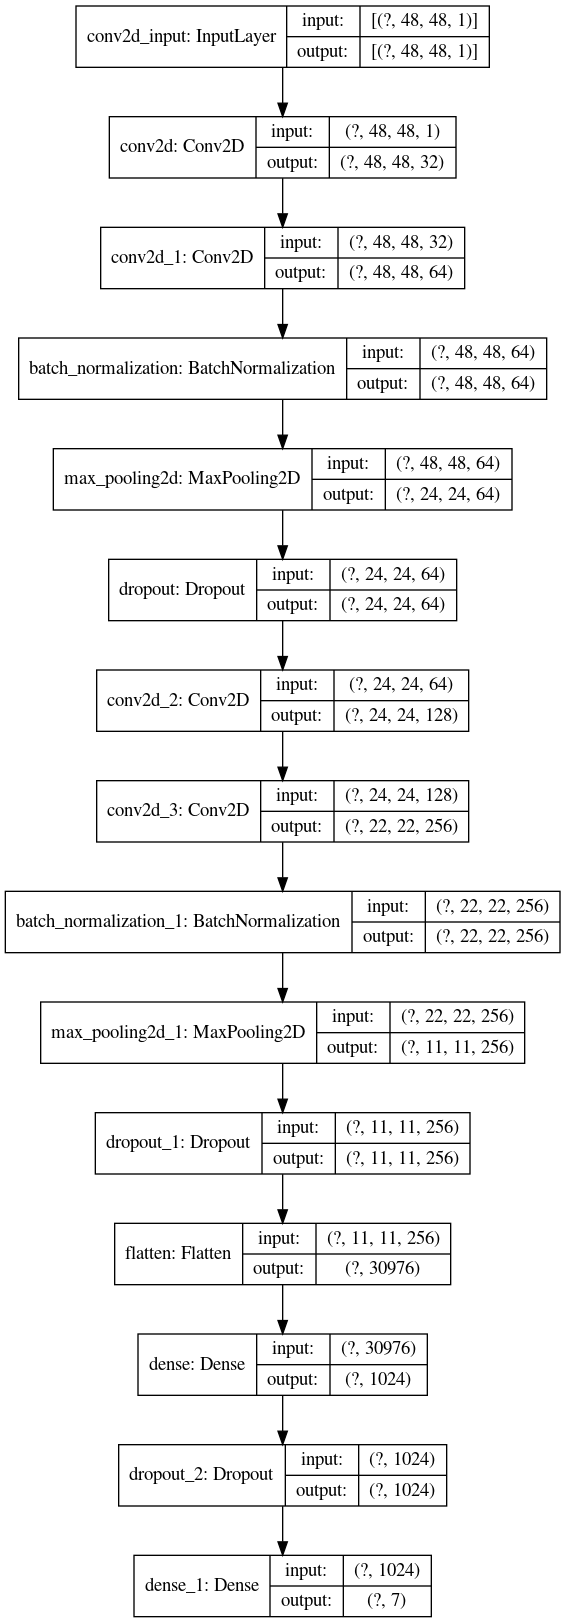

In [11]:
plot_model(emotions_classifier, to_file='emotions_classifier.png', show_shapes=True, show_layer_names=True)

### Callbacks Function

In [12]:
import datetime

chk_path = 'emotions_classifier.h5'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss')

earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

## Training Model

In [13]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

hist = emotions_classifier.fit(x=training_set,
                              validation_data=test_set,
                              epochs=60,
                              callbacks=callbacks,
                              steps_per_epoch=steps_per_epoch,
                              validation_steps=validation_steps)

Epoch 1/60
448/448 [==============================] - ETA: 0s - loss: 4.3405 - accuracy: 0.2773
Epoch 00001: val_loss improved from inf to 6.22485, saving model to emotions_classifier.h5
448/448 [==============================] - 153s 340ms/step - loss: 4.3405 - accuracy: 0.2773 - val_loss: 6.2248 - val_accuracy: 0.0993
Epoch 2/60
448/448 [==============================] - ETA: 0s - loss: 3.5392 - accuracy: 0.3346
Epoch 00002: val_loss improved from 6.22485 to 3.18148, saving model to emotions_classifier.h5
448/448 [==============================] - 40s 89ms/step - loss: 3.5392 - accuracy: 0.3346 - val_loss: 3.1815 - val_accuracy: 0.3938
Epoch 3/60
448/448 [==============================] - ETA: 0s - loss: 3.0153 - accuracy: 0.3668
Epoch 00003: val_loss improved from 3.18148 to 2.67098, saving model to emotions_classifier.h5
448/448 [==============================] - 41s 91ms/step - loss: 3.0153 - accuracy: 0.3668 - val_loss: 2.6710 - val_accuracy: 0.4308
Epoch 4/60
448/448 [==========

## Loss and Accuracy Plot

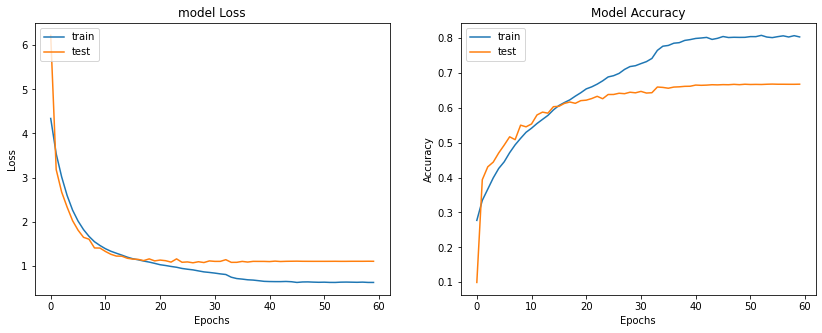

In [14]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Model Evaluation

In [15]:
train_loss, train_accu = emotions_classifier.evaluate(training_set)
test_loss, test_accu = emotions_classifier.evaluate(test_set)

print("final train accuracy = {:.2f}% , validation accuracy = {:.2f}%".format(train_accu*100, test_accu*100))

113/113 [==============================] - 6s 49ms/step - loss: 1.1015 - accuracy: 0.6676
final train accuracy = 87.97% , validation accuracy = 66.76%


In [16]:
emotions_classifier.save('emotions_classifier.h5')
emotions_classifier.save_weights('emotions_classifier_bestweight.h5')

In [17]:
emotions_classifier.save('emotions_classifier.json')

### Confusion Matrix and Classification on Training Set

Confusion Matrix
[[ 499   47  517 1056  718  712  446]
 [  59    7   67   95   77   85   46]
 [ 586   66  558 1022  724  687  454]
 [ 928  108  941 1919 1291 1235  793]
 [ 643   57  633 1258  954  849  571]
 [ 692   71  605 1220  905  822  515]
 [ 437   35  389  853  617  490  350]]
Classification Report
              precision    recall  f1-score   support

       angry       0.13      0.12      0.13      3995
     disgust       0.02      0.02      0.02       436
        fear       0.15      0.14      0.14      4097
       happy       0.26      0.27      0.26      7215
     neutral       0.18      0.19      0.19      4965
         sad       0.17      0.17      0.17      4830
    surprise       0.11      0.11      0.11      3171

    accuracy                           0.18     28709
   macro avg       0.15      0.15      0.15     28709
weighted avg       0.18      0.18      0.18     28709



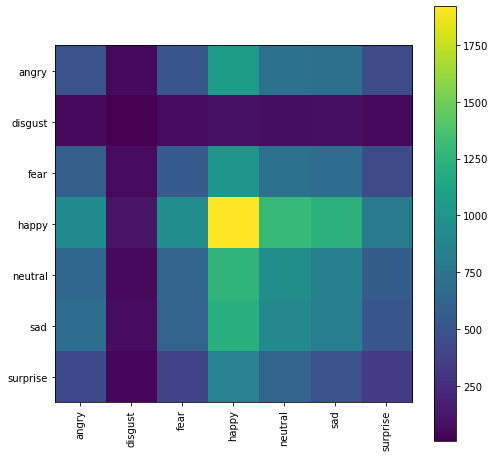

In [18]:
y_pred = emotions_classifier.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(training_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

### Confusion Matrix and Classification on Test Set

Confusion Matrix
[[142  11 106 244 164 172 119]
 [ 16   2  11  25  24  21  12]
 [129   8 109 283 205 172 118]
 [245  16 218 446 327 318 204]
 [178  17 138 288 243 222 147]
 [172   8 149 306 231 235 146]
 [125   6  94 202 180 132  92]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.15      0.14       958
     disgust       0.03      0.02      0.02       111
        fear       0.13      0.11      0.12      1024
       happy       0.25      0.25      0.25      1774
     neutral       0.18      0.20      0.19      1233
         sad       0.18      0.19      0.19      1247
    surprise       0.11      0.11      0.11       831

    accuracy                           0.18      7178
   macro avg       0.15      0.15      0.15      7178
weighted avg       0.17      0.18      0.18      7178



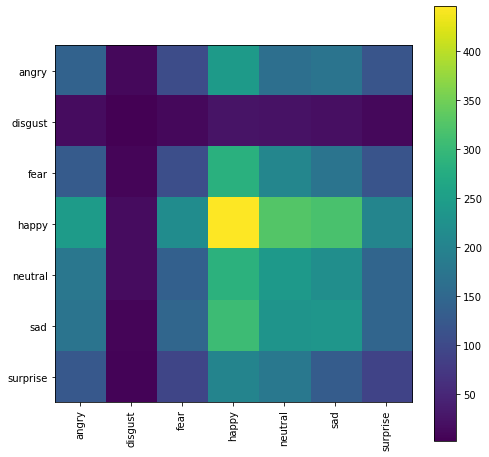

In [19]:
y_pred = emotions_classifier.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

#from sklearn.metrics import classification_report, confusion_matrix
cm_test = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)